# Flame Speed

In this example we simulate a freely-propagating, adiabatic, 1-D flame and
* Calculate its laminar burning velocity
* Perform a sensitivity analysis of its kinetics

The figure below illustrates the setup, in a flame-fixed coordinate system. The reactants enter with density $\rho_{u}$, temperature $T_{u}$ and speed $S_{u}$. The products exit the flame at speed $S_{b}$, density $\rho_{b}$ and temperature $T_{b}$.

<img src="./images/flameSpeed.png" alt="Freely Propagating Flame" style="width: 300px;"/>

In [1]:
import cantera as ct
import numpy as np

%matplotlib notebook
import matplotlib.pyplot as plt

print(f"Running Cantera version {ct.__version__}")

Running Cantera version 2.5.1


## Cantera Simulation Steps

Most Cantera simulations are accomplished by three steps:

1. Create a phase from an input file
2. Set boundary/input conditions
3. Run the simulation

In the case of an adiabatic free flame, Cantera has a built-in model to quickly calculate flame speeds.

### Define the reactant conditions, gas mixture and kinetic mechanism associated with the gas

In [2]:
gas = ct.Solution("gri30.yaml")

### Define flame simulation conditions

In [3]:
T0 = 300
P0 = ct.one_atm

# Domain width in meters
width = 0.02

gas.set_equivalence_ratio(1.0, "CH4", {"O2": 1.0, "N2": 3.76})
gas.TP = T0, P0

### Run the simulation

With the input conditions set, we need to create the appropriate flame object and run the simulation. The `FreeFlame` class can take either an array of grid points or a width. Specifying the width is preferred and Cantera will automatically set and refine a grid in the simulation.

In [4]:
flame = ct.FreeFlame(gas, width=width)

With 1-D flames, we need to consider species and energy transport by convection and diffusion. For species diffusion, there are several ways of calculating the binary diffusion coefficient of every pair of species. The simpler assumption is that the species is diffusing into an average mixture. The more complicated, but more accurate, assumption is to calculate the multi-component diffusion coefficients.

In this example, we are using the mixture-average assumption, with the `"Mix"` keyword. Using the `"Multi"` solution can substantially increase the time it takes to reach a solution.

However, you can start by solving the system with the mixture-average assumption and switch to the multicomponent assumption after a good initial solution has already been achieved.

In [5]:
flame.transport_model = 'Mix'

Cantera can automatically refine the solution grid to meet certain criteria. The `ratio` limits the maximum distance between two grid points, where as the `slope` and `curve` are related to the solution components. The `slope` criteria adds grid points in locations where the slope of the solution components exceeds the threshold, and the `curve` criteria adds grid points where the curvature of the solution components exceeds the threshold.

In [6]:
flame.set_refine_criteria(ratio=3, slope=0.1, curve=0.1)

Cantera's 1-D solver can produce several levels of output, depending on how much detail you want to see. If you're pretty sure a solution is going to work, then a `loglevel` of 0 (no output) or 1 (minimal output) will be appropriate. If a case is failing, you can increase `loglevel` up to a maximum of 8 to have more and more output from each solution step.

In [7]:
loglevel = 1

### Solve

The `auto` option in the solve function tries to automatically solve the flame by applying a few common techniques.

First, the flame is solved on a sparse grid with the transport calculations set to mixture averaged (even if the user has set them to multicomponent). Then grid refinement is enabled, with points added according to the values of the `ratio`, `slope`, and `curve` parameters in the `set_refine_criteria()` function.

If the initial solve on the sparse grid fails to converge, the simulation is attempted again, but this time with the energy equation disabled. Once the simulation has been solved on the refined grid with the mixture averaged transport, Cantera enables multicomponent transport and Soret diffusion, if they have been set by the user.

In general, it is recommended that you use the `auto` option the first time you run the solver, unless the simulation fails. On subsequent invocations of `solve`, you should not include the `auto` option (or set it to `False`).

In [8]:
flame.solve(loglevel=loglevel, auto=True)


************ Solving on 8 point grid with energy equation enabled ************

..............................................................................
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     2.136e-05      5.192
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     0.0005474      4.219
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     4.871e-05      5.598
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps       1.3e-05      6.147
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps     0.0004999      4.496
Attempt Newton solution of steady-state problem...    failure. 
Take 10 timesteps       0.01922      1.512
Attempt Newton solution of steady-state problem...    success.

Problem solved on [9] point grid(s).
Expanding domain to accommodate flame thickness. New width: 0.04 m
##############################

Attempt Newton solution of steady-state problem...    success.

Problem solved on [127] point grid(s).

..............................................................................
##############################################################################
Refining grid in flame.
    New points inserted after grid points 35 36 37 38 39 53 54 55 56 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 
    to resolve C2H2 C2H3 C2H5 C3H8 CH2 CH2OH CH3 CH3O HCCO HCO 
##############################################################################

..............................................................................
Attempt Newton solution of steady-state problem...    success.

Problem solved on [151] point grid(s).

..............................................................................
no new points needed in flame


In [9]:
Su0 = flame.velocity[0]
print(f"Flame Speed is: {Su0*100:.2f} cm/s")
flame.show_stats()

Flame Speed is: 38.32 cm/s

Statistics:

 Grid   Timesteps  Functions      Time  Jacobians      Time
   11          60       1351    0.9212         50    2.9531
   18           0       1971    2.2898         77    8.8632
   25          20        731    1.2208         29    5.2169
   34           0         61    0.1078          4    0.9167
   45          10        158    0.4959          5    1.5814
   56           0         13    0.0502          2    0.8380
   72           0         14    0.0801          1    0.5552
   95           0         10    0.0697          1    0.7445
  129           0          8    0.0731          1    0.9458
  153           0          6    0.0550          1    1.0808


### Plot figures

Check and see if all has gone well. Plot temperature and species fractions to see. We expect that the solution at the boundaries of the domain will have zero gradient (in other words, that the domain width that we specified is wide enough for the flame). Notice that Cantera automatically expanded the domain from 2 cm to 4 cm to accommodate the flame thickness.

#### Temperature Plot

<IPython.core.display.Javascript object>


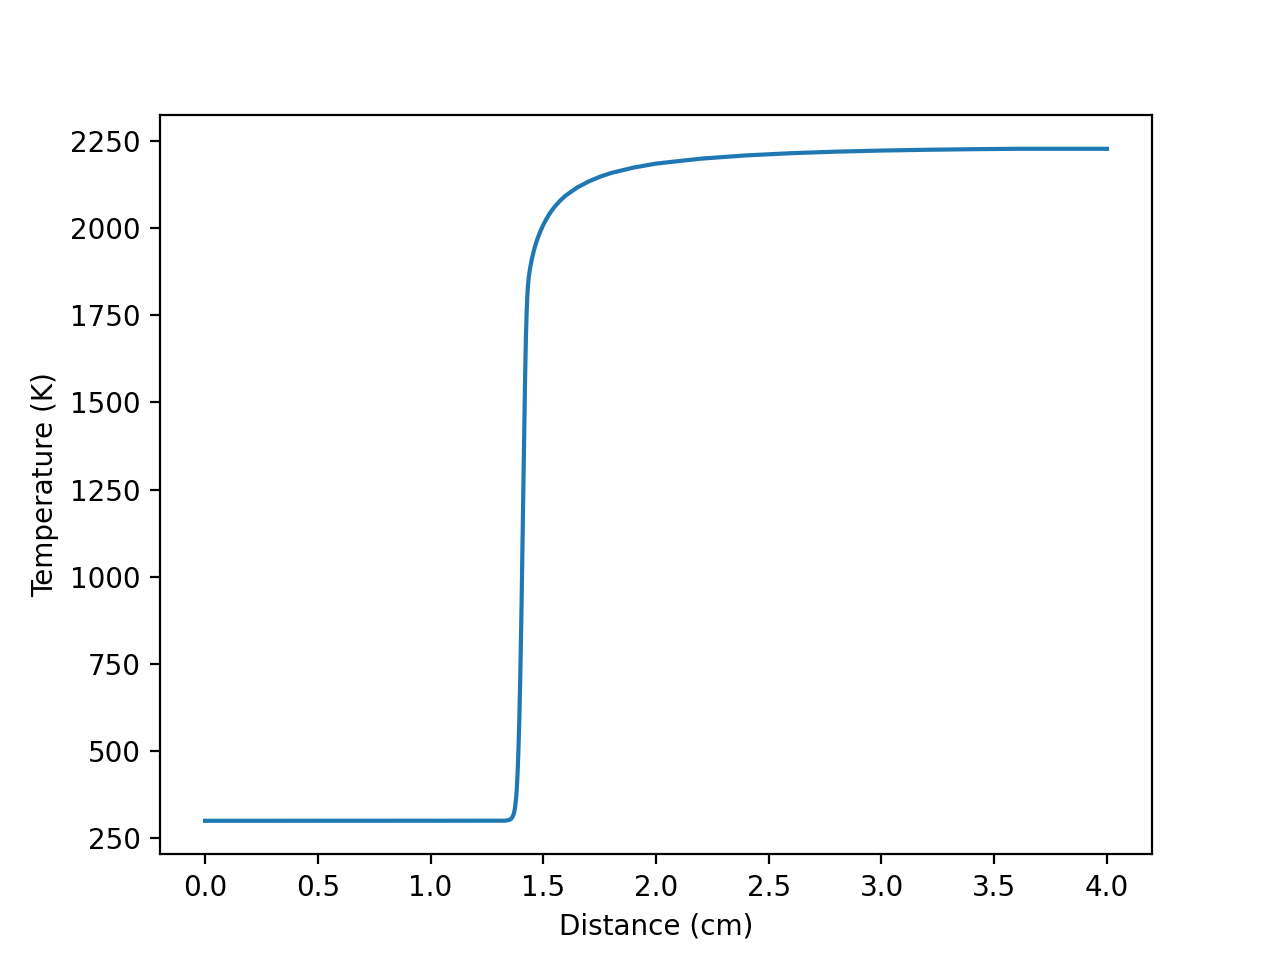

In [10]:
f, ax = plt.subplots()
ax.plot(flame.grid*100, flame.T)
ax.set(xlabel='Distance (cm)', ylabel='Temperature (K)');

## Sensitivity analysis
Compute normalized sensitivities of flame speed $S_u$ to changes in the rate coefficient $k_i$ for each reaction
$$s_i = \frac{k_i}{S_u} \frac{d S_u}{d k_i}$$

Note that this will be much slower when multicomponent or Soret diffusion are turned on.

In [14]:
sens = flame.get_flame_speed_reaction_sensitivities()

In [15]:
sens_data = sorted(zip(sens, gas.reaction_equations()), key=lambda item: abs(item[0]), reverse=True)
for s, eq in sens_data[:20]:
    print(f"{s:.2e}  {eq}")

5.35e-01  H + O2 <=> O + OH
-1.62e-01  CH3 + H (+M) <=> CH4 (+M)
1.15e-01  CO + OH <=> CO2 + H
7.43e-02  CH3 + OH <=> CH2(S) + H2O
7.31e-02  CH3 + HO2 <=> CH3O + OH
-7.03e-02  H + H2O + O2 <=> H2O + HO2
5.84e-02  H2O + HCO <=> CO + H + H2O
5.32e-02  CH3 + O => CO + H + H2
4.53e-02  HCO + M <=> CO + H + M
-3.97e-02  H + HO2 <=> H2 + O2
-3.92e-02  CH4 + OH <=> CH3 + H2O
-3.90e-02  H + HCO <=> CO + H2
-3.80e-02  CH4 + H <=> CH3 + H2
-3.74e-02  2 CH3 (+M) <=> C2H6 (+M)
-3.42e-02  H + OH + M <=> H2O + M
-3.04e-02  HCO + O2 <=> CO + HO2
2.79e-02  H2 + O <=> H + OH
2.69e-02  CH2 + O2 => CO2 + 2 H
-2.07e-02  HCO + OH <=> CO + H2O
1.90e-02  CH2(S) + O2 <=> CO + H + OH


## Solving multiple flames (parameter sweep) 

Cantera also makes it easy to re-use solutions from previous flames to compute conditions for a similar flame. This is very useful when doing a parameter sweep. In this case, we are going to sweep over a range of equivalence ratios. We will start at the lower limit of the equivalence ratio range we are interested in, 0.6.

In [16]:
gas.set_equivalence_ratio(0.6, 'CH4', {'O2':1.0, 'N2':3.76})
gas.TP = T0, P0

width = 0.04

flame = ct.FreeFlame(gas, width=width)

In the grid refinement criteria, it is important that we add one more condition, `prune`. This parameter controls when grid points can be removed from the simulation. Since we are conducting a sweep of equivalence ratios here, we expect the flame thickness to vary so that the number of grid points necessary will vary as well. Without `prune`, the number of grid points could never decrease and it would slow down some of the solutions.

In [17]:
flame.set_refine_criteria(ratio=3, slope=0.15, curve=0.15, prune=0.1)

Now we will solve the flame. For this first case, we are going to set `auto=True`.

In [18]:
flame.solve(loglevel=1, auto=True)

Now we will construct the range of equivalence ratios to loop over. Notice that the rest of these solutions are conducted with `auto=False`, since we are starting from a known-good solution.

In [19]:
phis = np.linspace(0.6, 1.4, 9)
Su = []

for phi in phis:
    print(f"phi = {phi:.1f}: ", end="")
    gas.set_equivalence_ratio(phi, "CH4", {"O2": 1.0, "N2": 3.76})
    flame.inlet.Y = gas.Y
    flame.solve(loglevel=0, auto=False)
    print(f"Su = {flame.velocity[0]*100:5.2f} cm/s, N = {len(flame.grid)}")
    Su.append(flame.velocity[0])

phi = 0.600: Su = 11.65 cm/s, N = 90
phi = 0.700: Su = 19.67 cm/s, N = 117
phi = 0.800: Su = 27.73 cm/s, N = 130
phi = 0.900: Su = 34.38 cm/s, N = 133
phi = 1.000: Su = 38.46 cm/s, N = 136
phi = 1.100: Su = 38.77 cm/s, N = 137
phi = 1.200: Su = 34.19 cm/s, N = 136
phi = 1.300: Su = 24.42 cm/s, N = 137
phi = 1.400: Su = 14.41 cm/s, N = 148


<IPython.core.display.Javascript object>


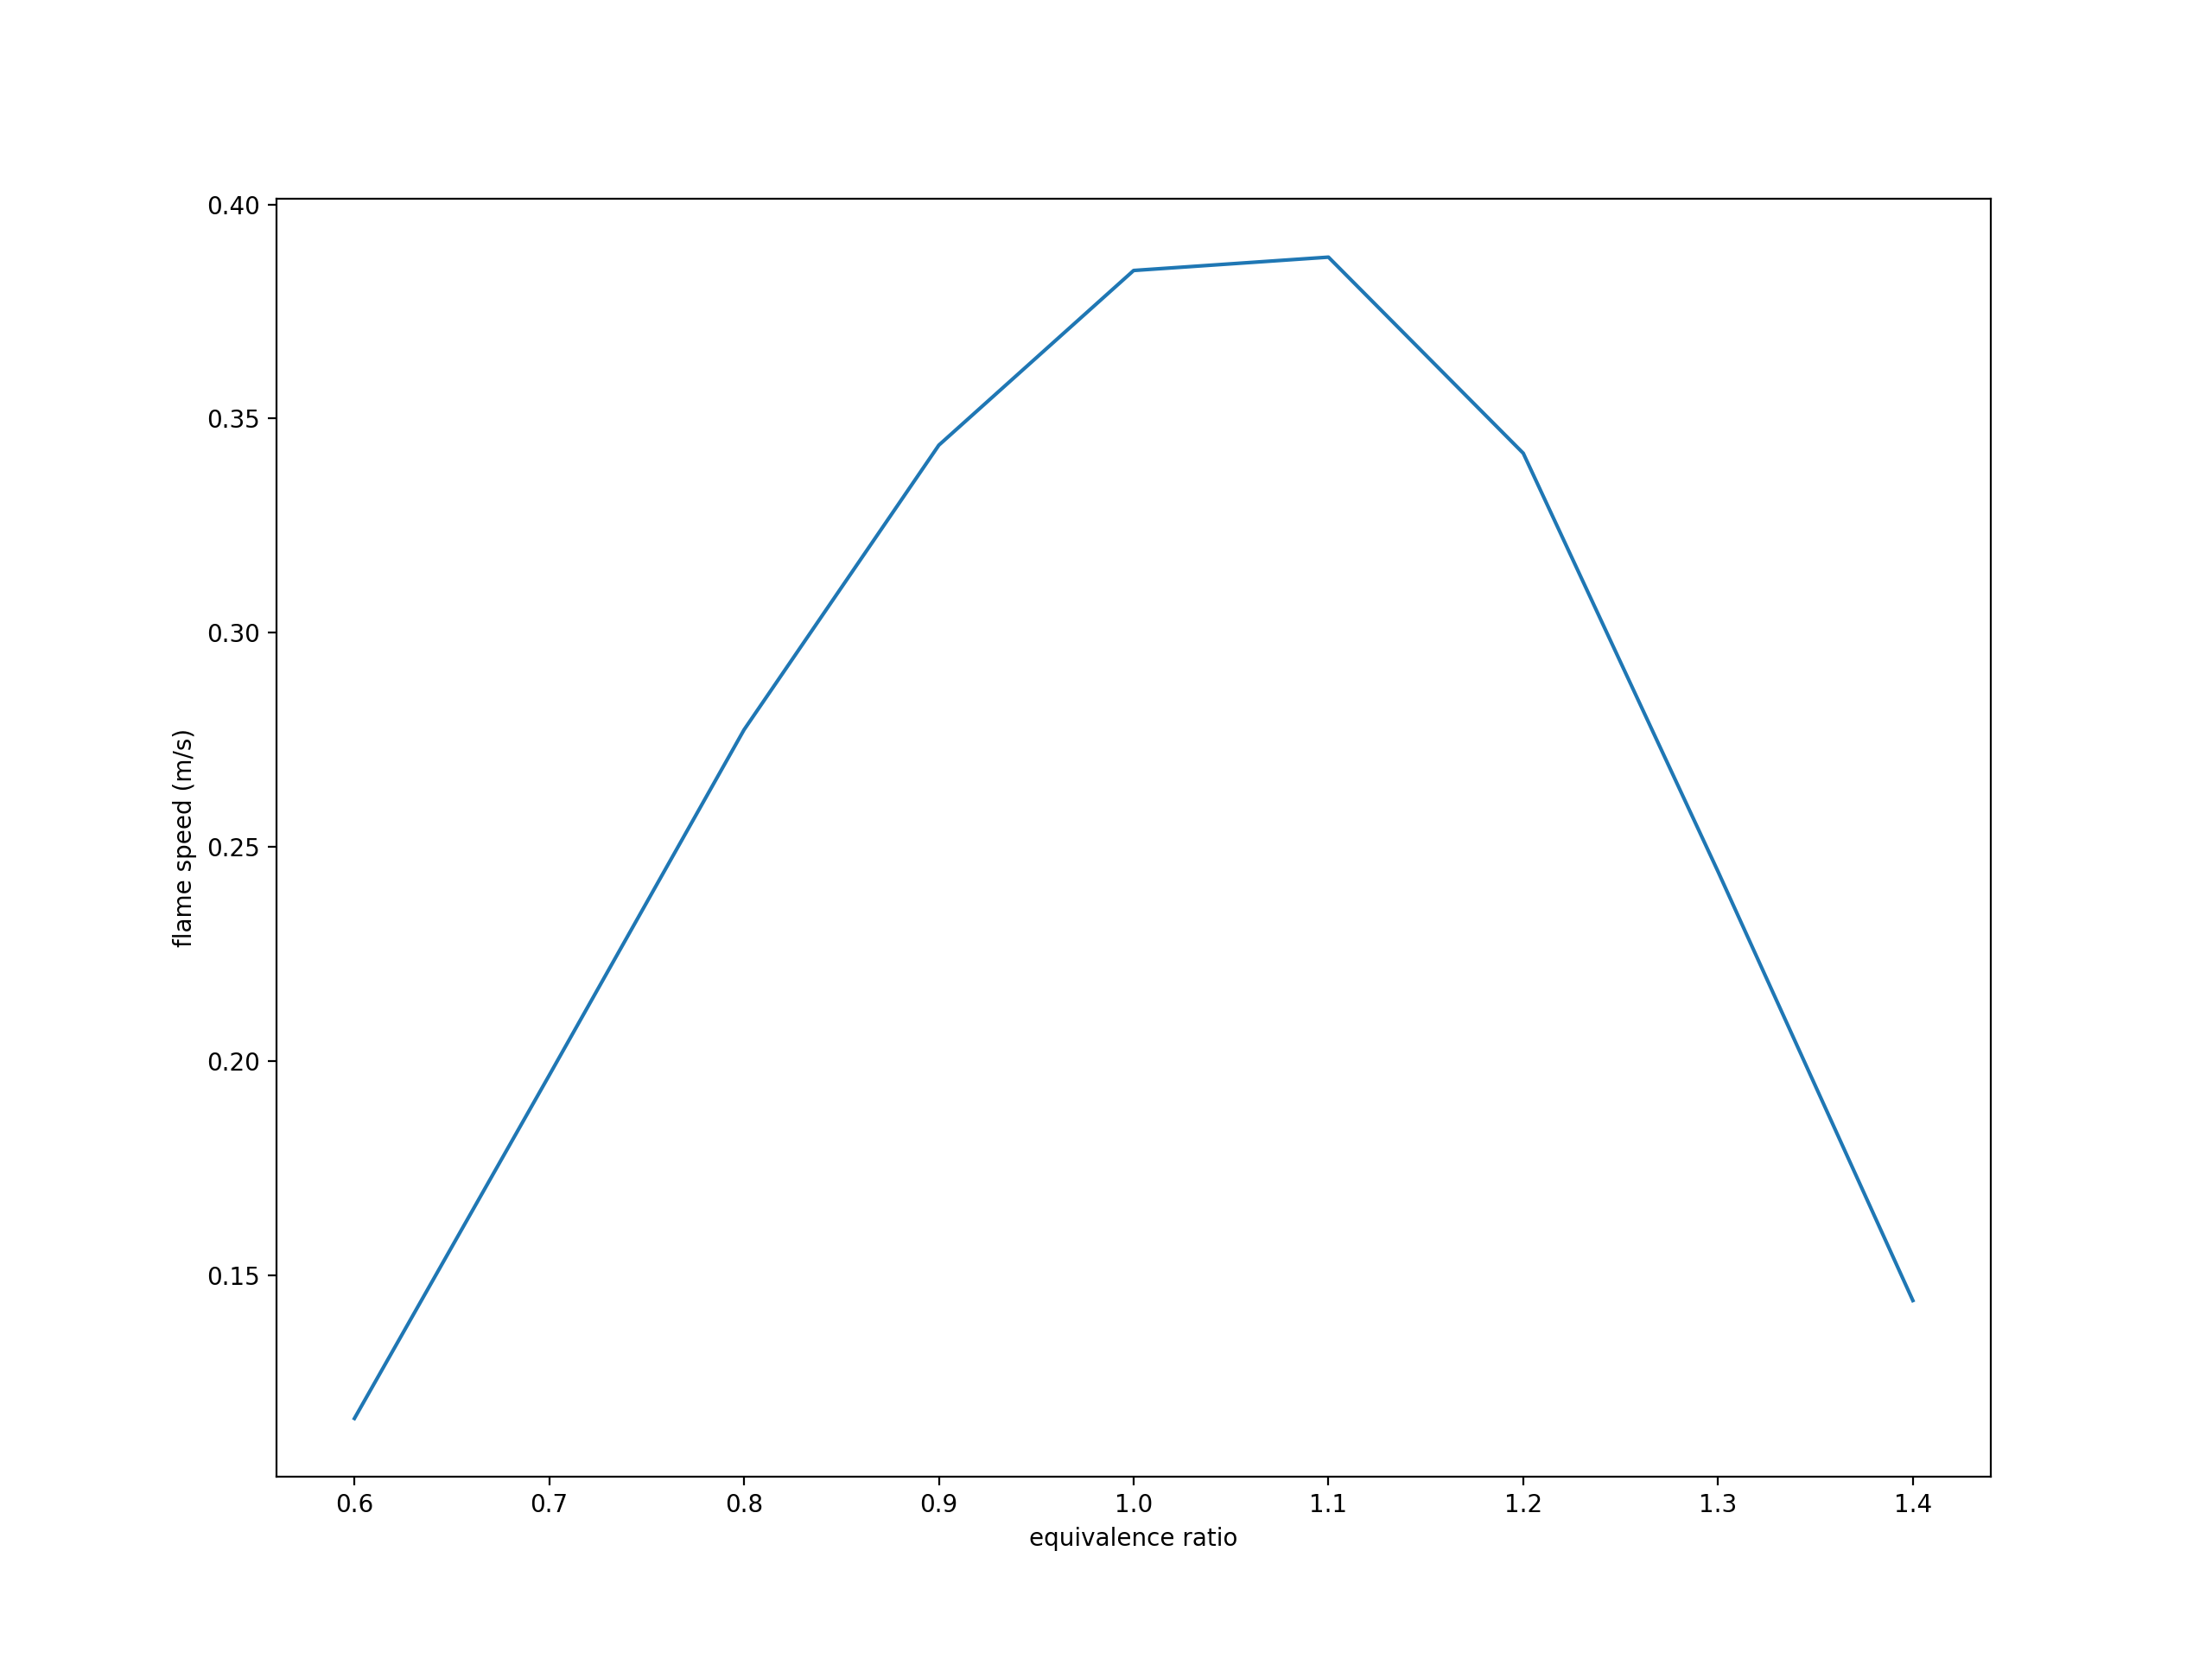

In [20]:
f, ax = plt.subplots()
ax.plot(phis, Su)
ax.set(xlabel="equivalence ratio", ylabel="flame speed (m/s)");